In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import pickle

# Exploring the data

In [2]:
df = pd.read_csv("/content/drive/MyDrive/ML_projects/Bulldozer_price_prediction/TrainAndValid.csv",
                 low_memory=False,  # low_memory = false, means do not worry about ram, we have enough
                 parse_dates=["saledate"])  # parse_dates tell pandas whether some column is of datatype or not
print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

# Visualizing the data

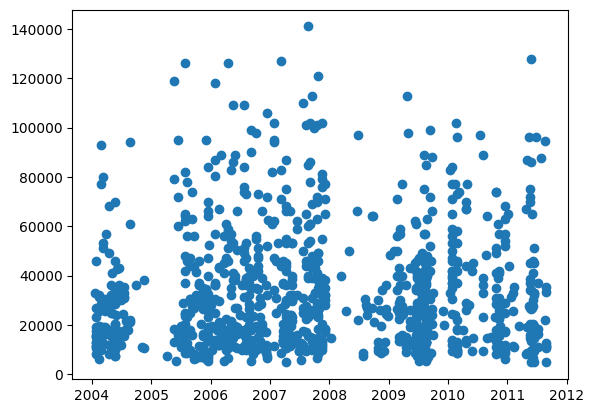

In [3]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])
plt.show()
# the problem with this plot is that the x-label is overcrowded due to the issue that matplotlib does not
# recognize it as date but rather as some random integer values to fix this we can use 'timeparse'

# Sort data frame by sale date

In [4]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)
print(df["saledate"].head())

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]


# Making the copy of the original dataframe

In [5]:
# Making the copy of the original dataframe---------------------------------------------------------
df_temp = df.copy()
print(df_temp["saledate"].head(20))

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]


# Adding datetime parameters for saledate column

In [6]:
df_temp["saleYear"] = df_temp["saledate"].dt.year
df_temp["saleMonth"] = df_temp["saledate"].dt.month
df_temp["saleDay"] = df_temp["saledate"].dt.day
df_temp["saleDayofWeek"] = df_temp["saledate"].dt.dayofweek
df_temp["saleDayofYear"] = df_temp["saledate"].dt.dayofyear
df_temp.drop("saledate", axis=1, inplace=True)

print(df_temp.head().T)

                                                                     205615  \
SalesID                                                             1646770   
SalePrice                                                            9500.0   
MachineID                                                           1126363   
ModelID                                                                8434   
datasource                                                              132   
auctioneerID                                                           18.0   
YearMade                                                               1974   
MachineHoursCurrentMeter                                                NaN   
UsageBand                                                               NaN   
fiModelDesc                                                            TD20   
fiBaseModel                                                            TD20   
fiSecondaryDesc                                     

# Converting string into pandas categorical datatype

In [7]:
for label, content in df_temp.items():
    if pd.api.types.is_float_dtype(content):
        pass
    else:
        if pd.api.types.is_string_dtype(content) or content.apply(pd.isnull).any():
            df_temp[label] = content.astype("category").cat.as_ordered()

# Saving the processed data

In [9]:
df_temp.info()
df_temp.to_csv("/content/drive/MyDrive/ML_projects/Bulldozer_price_prediction/data/train_temp.csv")
df_temp.to_pickle("/content/drive/MyDrive/ML_projects/Bulldozer_price_prediction/Models/train_temp.pkl")
# There is a problem in pandas.to_csv() it does not store the changed datatypes so to resolve this issue
# we have used pickle

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

# Retrieving data from the saved file

In [10]:
df_temp = pd.read_pickle("/content/drive/MyDrive/ML_projects/Bulldozer_price_prediction/Models/train_temp.pkl")
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

# Filling numerical missing values

In [11]:
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_temp[label + "_is_missing"] = pd.isnull(content)
            df_temp[label] = content.fillna(content.median())

# Turn categorical variables into numbers and fill missing

In [12]:
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_temp[label + "_is_missing"] = pd.isnull(content)
        df_temp[label] = pd.Categorical(content).codes + 1  # This will extract the categorical code and fill
        # the code in the label if the data is missing then it is filled with -1 therefore we are adding +1
        # so that it becomes 0

# Splitting the data

In [13]:
df_val = df_temp[df_temp.saleYear == 2012]
df_train = df_temp[df_temp.saleYear != 2012]

X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_val, y_val = df_val.drop("SalePrice", axis=1), df_val.SalePrice

# Building an evaluation function

In [14]:
def rmsle(y_test, y_preds):
    """
    Calculate the root mean squared log error
    :param y_test: original data with labels
    :param y_preds: predicted data with labels
    :return: root mean squared log error
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))


def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_val, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_val, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_val, val_preds)}

    return scores

# Model

In [15]:
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)
model.fit(X_train, y_train)
print(show_scores(model))

{'Training MAE': 5561.2988092240585, 'Valid MAE': 7177.26365505919, 'Training RMSLE': 0.257745378256977, 'Valid RMSLE': 0.29362638671089003, 'Training R^2': 0.8606658995199189, 'Valid R^2': 0.8320374995090507}


# Hyper-parameter tuning

In [16]:
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

# Ideal model

In [17]:
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)
ideal_model.fit(X_train, y_train)
print(show_scores(ideal_model))

{'Training MAE': 2953.8161137163484, 'Valid MAE': 5951.247761444453, 'Training RMSLE': 0.14469006962371858, 'Valid RMSLE': 0.24524163989538328, 'Training R^2': 0.9588145522577225, 'Valid R^2': 0.8818019502450094}
